# Do the realistic lossy polymer wl study

We have 6 and 8 tube fibers. Now doing the 6 tube

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ngsolve.webgui import Draw
from ngsolve import CF

from fiberamp.fiber.microstruct.bragg import BraggExact
from step_exact import plotlogf
from scipy.optimize import newton

importing NGSolve-6.2.2203-56-g47f483033


# Mode Profiles

In [14]:
n_air = 1.00027717
n_glass = 1.4388164768221814
n_poly = 1.5 - 2.4e-3

ts = [15e-6, .42e-6, 12.48e-6, 10e-6, 60e-6, 10e-6]
ns = [lambda x:n_air, lambda x:n_glass,
      lambda x:n_air, lambda x:n_glass,
      lambda x:n_poly, lambda x:n_air]

mats = ['air','glass','air','glass','polymer','air']
maxhs = [.2, .1, .2, .1, .1, 10]
scale = 15e-6
wl = 1.8e-6

In [15]:
A = BraggExact(ts=ts, ns=ns, mats=mats, maxhs=maxhs, scale=scale, wl=wl)


In [16]:
Draw(CF(list(A.ns)), A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

In [17]:
# k_low = A.k0 * A.ns[0] * A.scale
k_low, k_high = A.k0 * np.min(A.ns.real) * A.scale, A.k0 * np.max(A.ns.real) * A.scale

outer = 'h2'
Ktype = 'kappa'
nu = 1

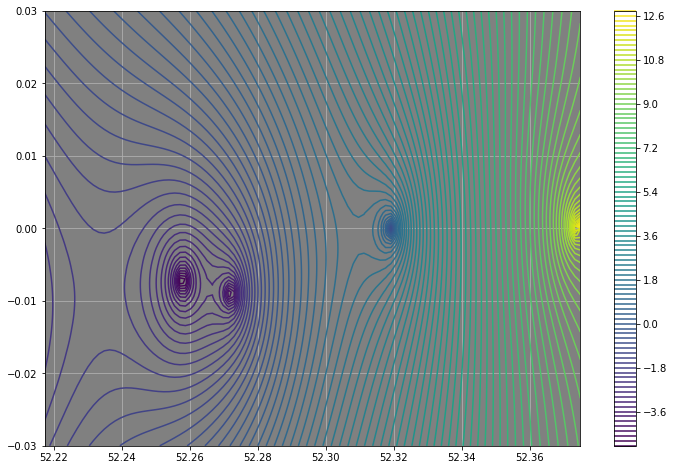

In [21]:
%matplotlib inline
plotlogf(A.determinant, .997*k_low, 1.00001*k_low, -.03,.03, nu, outer,
         iref=100, rref=100, levels=100)

In [23]:
guess = np.array(.9999*k_low)

beta1 = newton(A.determinant, guess, args=(nu, outer, Ktype), tol = 1e-16)

print("Scaled beta: ", beta1, ". Residual of determinant: ", abs(A.determinant(beta1, nu, outer, Ktype)))


Scaled beta:  (52.31914528346508-1.3379832665705019e-05j) . Residual of determinant:  4.577566798522238e-13


In [24]:
Fs = A.all_fields(beta1, nu=nu, outer=outer, Ktype=Ktype)

In [25]:
Draw(10*Fs['Ez'], A.mesh)

WebGuiWidget(value={'ngsolve_version': '6.2.2203-56-g47f483033', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'd…

BaseWebGuiScene

# Wavelength Studies

## N2 reference fiber

In [29]:
n = 300
wls = np.linspace(1e-6, 2e-6, n+1)
betasN2 = np.zeros_like(wls, dtype=complex)
outer = 'h2'
nu = 1

n_air = 1.00027717
n_glass = 1.4388164768221814

In [30]:
ts = [15e-6, .42e-6, 12.48e-6, 10e-6]
ns = [lambda x:n_air, lambda x:n_glass,
      lambda x:n_air, lambda x:n_glass]

mats = ['air','glass','air','glass']
maxhs = [.2, .1, .2, .1]
scale = 15e-6


In [31]:
for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
    
    A = BraggExact(ts=ts, ns=ns , mats=mats,maxhs=maxhs, wl=wl, scale=scale,
                  no_mesh=True)
    k_low = A.ks[0] * A.scale
    guess = np.array(.99999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.99999
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .99999
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betasN2[i] = beta
    

     --------------------  1/301: wavelength: 1e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (94.24538682009158-1.0903889609704713e-05j) . Residual of determinant:  2.4218024834354387e-12 


     --------------------  2/301: wavelength: 1.0033333333333332e-06  --------------------     

Scaled beta:  (93.93204612585254-1.0658530599380019e-05j) . Residual of determinant:  1.2612951437780595e-13 


     --------------------  3/301: wavelength: 1.0066666666666666e-06  --------------------     

Scaled beta:  (93.62078123892856-1.0428692708357794e-05j) . Residual of determinant:  1.3885616703545978e-12 


     --------------------  4/301: wavelength: 1.0099999999999999e-06  --------------------     

Scaled beta:  (93.31157151159941-1.0213184070544014e-05j) . Residual of determinant:  4.277971736831723e-13 


     --------------------  5/301: wavelength: 1.0133333333333333e-06  --------------------     

Scaled beta:  (93.00439657612559-1.0010928566557402

scaling guess: 1
Scaled beta:  (83.14946855918362-7.1243996081874494e-06j) . Residual of determinant:  1.9249094010525007e-12 


     --------------------  42/301: wavelength: 1.1366666666666667e-06  --------------------     

Scaled beta:  (82.90541749003206-7.106344955035242e-06j) . Residual of determinant:  4.987716557626639e-13 


     --------------------  43/301: wavelength: 1.1399999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (82.6627931552879-7.090082518888285e-06j) . Residual of determinant:  3.2871120667006248e-12 


     --------------------  44/301: wavelength: 1.1433333333333333e-06  --------------------     

Scaled beta:  (82.42158306995373-7.075553598102676e-06j) . Residual of determinant:  1.4328062287549166e-12 


     --------------------  45/301: wavelength: 1.1466666666666666e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (82.18177489448601-7.062702765241239e-06j) . Resi

Scaled beta:  (74.78296434422043-7.371112304475565e-06j) . Residual of determinant:  1.8117255007801234e-12 


     --------------------  80/301: wavelength: 1.2633333333333332e-06  --------------------     

Scaled beta:  (74.5854394576882-7.397438529803725e-06j) . Residual of determinant:  3.1320186621798534e-13 


     --------------------  81/301: wavelength: 1.2666666666666667e-06  --------------------     

Scaled beta:  (74.38895364393659-7.424589840717516e-06j) . Residual of determinant:  1.4635018461685935e-12 


     --------------------  82/301: wavelength: 1.27e-06  --------------------     

Scaled beta:  (74.19349871981183-7.452558731706691e-06j) . Residual of determinant:  2.5055388468537596e-12 


     --------------------  83/301: wavelength: 1.2733333333333331e-06  --------------------     

Scaled beta:  (73.99906658788503-7.481338129365365e-06j) . Residual of determinant:  1.535040355386683e-12 


     --------------------  84/301: wavelength: 1.2766666666666666e-06

Scaled beta:  (67.61875504017942-9.024079309707004e-06j) . Residual of determinant:  1.0007173262561494e-12 


     --------------------  120/301: wavelength: 1.3966666666666667e-06  --------------------     

Scaled beta:  (67.45716519521937-9.080645409629145e-06j) . Residual of determinant:  1.7593608536066232e-12 


     --------------------  121/301: wavelength: 1.4e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.2963443079356-9.137956220590016e-06j) . Residual of determinant:  2.812487573276975e-12 


     --------------------  122/301: wavelength: 1.4033333333333332e-06  --------------------     

Scaled beta:  (67.13628689818204-9.19601344249992e-06j) . Residual of determinant:  4.80578359164454e-13 


     --------------------  123/301: wavelength: 1.4066666666666666e-06  --------------------     

Scaled beta:  (66.97698753776474-9.254818891568673e-06j) . Residual of determinant:  3.0070591680138315e-12 


     --------------------  124/301: wavelength: 1.40

Scaled beta:  (61.84041140873569-1.1805859323143067e-05j) . Residual of determinant:  1.1624251418303739e-12 


     --------------------  159/301: wavelength: 1.5266666666666665e-06  --------------------     

Scaled beta:  (61.705178965062515-1.1893624136987782e-05j) . Residual of determinant:  7.635552890361098e-13 


     --------------------  160/301: wavelength: 1.5299999999999998e-06  --------------------     

Scaled beta:  (61.57053527650076-1.1982268791837658e-05j) . Residual of determinant:  1.6181754031275227e-12 


     --------------------  161/301: wavelength: 1.5333333333333332e-06  --------------------     

Scaled beta:  (61.43647650291476-1.207179827137215e-05j) . Residual of determinant:  2.358624525407295e-12 


     --------------------  162/301: wavelength: 1.5366666666666666e-06  --------------------     

Scaled beta:  (61.30299883749089-1.216221762358344e-05j) . Residual of determinant:  6.312042625534048e-13 


     --------------------  163/301: wavelength: 

Scaled beta:  (56.85522678715198-1.6057581072920343e-05j) . Residual of determinant:  2.0122296591073357e-13 


     --------------------  199/301: wavelength: 1.6599999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (56.74084832671046-1.618502765795958e-05j) . Residual of determinant:  1.1664725680939656e-12 


     --------------------  200/301: wavelength: 1.6633333333333332e-06  --------------------     

Scaled beta:  (56.62692782863346-1.63136001641207e-05j) . Residual of determinant:  7.013987706292053e-13 


     --------------------  201/301: wavelength: 1.6666666666666667e-06  --------------------     

Scaled beta:  (56.51346254479166-1.6443305913490786e-05j) . Residual of determinant:  1.6508728113247828e-12 


     --------------------  202/301: wavelength: 1.6699999999999999e-06  --------------------     

Scaled beta:  (56.40044974899741-1.6574152283782048e-05j) . Residual of determinant:  1.619178187724014e-13 


     --------------------  203/3

Scaled beta:  (52.710388648399515-2.1933804972323117e-05j) . Residual of determinant:  1.3055519793068562e-12 


     --------------------  238/301: wavelength: 1.7899999999999998e-06  --------------------     

Scaled beta:  (52.612018294707795-2.2111098118290032e-05j) . Residual of determinant:  1.1567325530187651e-14 


     --------------------  239/301: wavelength: 1.7933333333333332e-06  --------------------     

Scaled beta:  (52.514013182943486-2.2289844224454703e-05j) . Residual of determinant:  1.5879711745080805e-13 


     --------------------  240/301: wavelength: 1.7966666666666667e-06  --------------------     

Scaled beta:  (52.416371279895166-2.2470052813339846e-05j) . Residual of determinant:  3.762317634968185e-13 


     --------------------  241/301: wavelength: 1.8e-06  --------------------     

Scaled beta:  (52.31909056741211-2.2651733465631164e-05j) . Residual of determinant:  8.038165676513289e-13 


     --------------------  242/301: wavelength: 1.8033333

Scaled beta:  (49.04166544797262-3.0258337062102368e-05j) . Residual of determinant:  5.619442396793138e-13 


     --------------------  278/301: wavelength: 1.9233333333333333e-06  --------------------     

Scaled beta:  (48.956455888019136-3.0501764588740074e-05j) . Residual of determinant:  2.787615716202416e-13 


     --------------------  279/301: wavelength: 1.9266666666666663e-06  --------------------     

Scaled beta:  (48.87154074242602-3.074707284014154e-05j) . Residual of determinant:  3.147118849149137e-13 


     --------------------  280/301: wavelength: 1.9299999999999997e-06  --------------------     

Scaled beta:  (48.78691848542117-3.0994273785953125e-05j) . Residual of determinant:  9.952853799207733e-13 


     --------------------  281/301: wavelength: 1.933333333333333e-06  --------------------     

Scaled beta:  (48.70258760175483-3.1243379460427516e-05j) . Residual of determinant:  2.3010994774673587e-13 


     --------------------  282/301: wavelength: 1

<IPython.core.display.Javascript object>


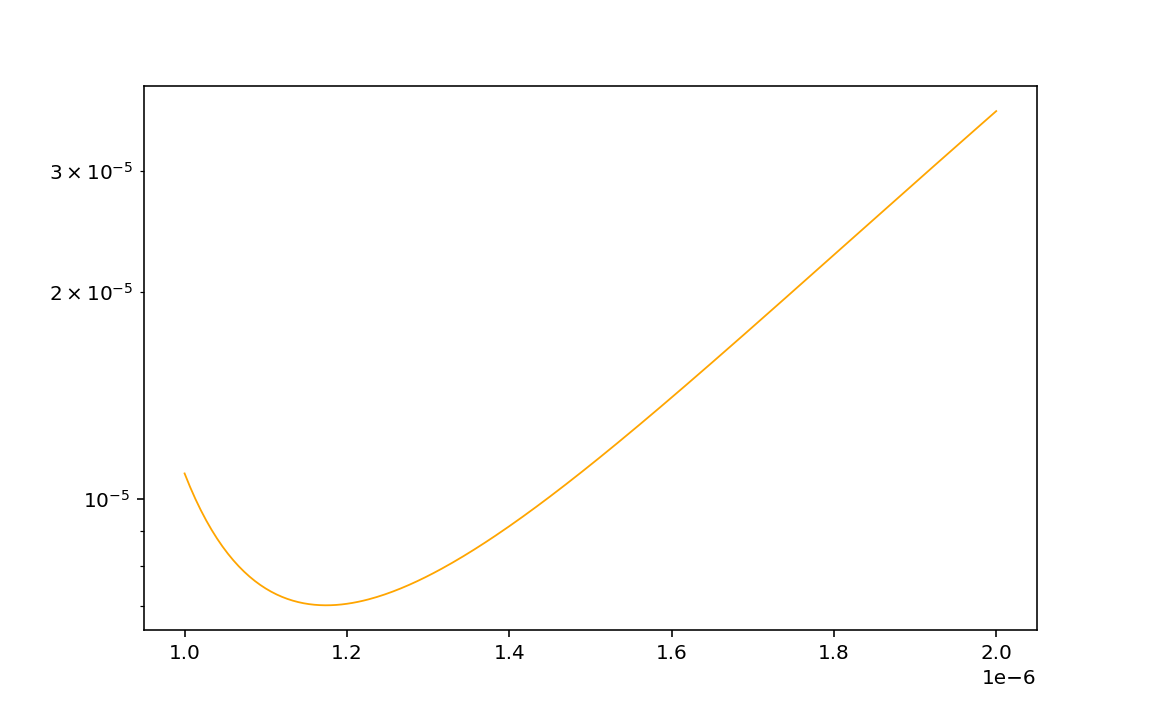

In [32]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(wls, -betasN2.imag, color='orange', linewidth=.9)
plt.yscale('log')


# N3 Model

In [58]:
n = 300
betasN3 = np.zeros_like(wls, dtype=complex)
outer = 'h2'
nu = 1

n_air = 1.00027717
n_glass = 1.4388164768221814


In [59]:
ts = [15e-6, .42e-6, 12.48e-6, 70e-6, 10e-6]
ns = [lambda x:n_air, lambda x:n_glass,
      lambda x:n_air, lambda x:n_glass,
      lambda x:n_air]

mats = ['air','glass','air','glass','air']
maxhs = [.2, .01, .2, .01, 10]


Having a hard time getting the fundamental, it's jumping to a higher order mode, let's look where it is.

In [60]:
A = BraggExact(ts=ts, ns=ns , mats=mats, maxhs=maxhs, wl=wls[0], scale=scale,
              no_mesh=True)

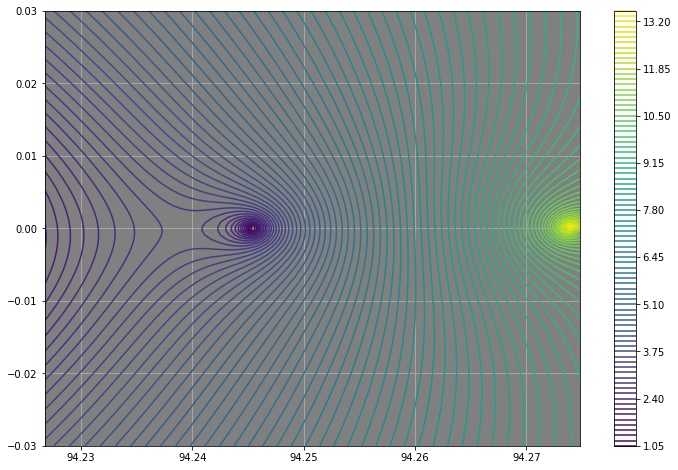

In [61]:
%matplotlib inline
k_low = A.ks[0] * A.scale

plotlogf(A.determinant, .9995*k_low, 1.00001*k_low, -.03,.03, nu, outer,
         iref=100, rref=100, levels=100)

Lower than I thought, okay

In [62]:
guess = np.array(.9998*k_low)

beta1 = newton(A.determinant, guess, args=(nu, outer, Ktype), tol = 1e-16)

print("Scaled beta: ", beta1, ". Residual of determinant: ", abs(A.determinant(beta1, nu, outer, Ktype)))


Scaled beta:  (94.24540634696989-2.0809600380523243e-06j) . Residual of determinant:  2.3841576028179254e-10


In [63]:
for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
    
    A = BraggExact(ts=ts, ns=ns , mats=mats, maxhs=maxhs, wl=wl, scale=scale,
                  no_mesh=True)
    k_low = A.ks[0] * A.scale
    guess = np.array(.9999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999995
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999995
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betasN3[i] = beta
    

     --------------------  1/301: wavelength: 1e-06  --------------------     

Scaled beta:  (94.2454063469699-2.080960038044369e-06j) . Residual of determinant:  6.358166284051292e-11 


     --------------------  2/301: wavelength: 1.0033333333333332e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (93.93204105472554-5.953641044937862e-07j) . Residual of determinant:  9.075608577593082e-12 


     --------------------  3/301: wavelength: 1.0066666666666666e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (93.62080732279931-3.4768802704163564e-06j) . Residual of determinant:  4.624903672640937e-11 


     --------------------  4/301: wavelength: 1.0099999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (93.31156841918845-5.116419077849938e-07j) . Residual of determinant:  4.70383424653489e-10 


     --------------------  5/301: wavelength: 1.0133333333333333e-06  -

Scaled beta:  (83.3949485215333-1.1836117164297158e-06j) . Residual of determinant:  1.1815890303996386e-10 


     --------------------  41/301: wavelength: 1.1333333333333332e-06  --------------------     

Scaled beta:  (83.14947912676774-1.1932101293737205e-06j) . Residual of determinant:  7.77983557293934e-11 


     --------------------  42/301: wavelength: 1.1366666666666667e-06  --------------------     

scaling guess: 1
Scaled beta:  (82.90541609321994-3.871003266860607e-07j) . Residual of determinant:  1.9694192310722096e-10 


     --------------------  43/301: wavelength: 1.1399999999999999e-06  --------------------     

Scaled beta:  (82.66276155612086-8.381749966925083e-06j) . Residual of determinant:  2.0851349947818443e-12 


     --------------------  44/301: wavelength: 1.1433333333333333e-06  --------------------     

Scaled beta:  (82.4215880426112-5.571455571428573e-07j) . Residual of determinant:  3.178755455478127e-10 


     --------------------  45/301: wave

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (74.98153055050626-7.199569798793542e-07j) . Residual of determinant:  1.1277961805875544e-10 


     --------------------  79/301: wavelength: 1.26e-06  --------------------     

Scaled beta:  (74.783026577183-4.622909980878925e-05j) . Residual of determinant:  7.691954789931658e-12 


     --------------------  80/301: wavelength: 1.2633333333333332e-06  --------------------     

scaling guess: 1
Scaled beta:  (74.58544389889008-5.898073646041389e-07j) . Residual of determinant:  2.3920724821750663e-10 


     --------------------  81/301: wavelength: 1.2666666666666667e-06  --------------------     

Scaled beta:  (74.38895048188132-5.168636868247181e-07j) . Residual of determinant:  2.0795862440781522e-10 


     --------------------  82/301: wavelength: 1.27e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling 

Scaled beta:  (68.77189514140244-1.1294148316879748e-06j) . Residual of determinant:  3.637512552932051e-11 


     --------------------  113/301: wavelength: 1.3733333333333332e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (68.60475577195784-5.568773927864897e-07j) . Residual of determinant:  1.6599995262108072e-10 


     --------------------  114/301: wavelength: 1.3766666666666665e-06  --------------------     

Scaled beta:  (68.43842510600146-1.1708582818302512e-06j) . Residual of determinant:  1.0251591436560584e-10 


     --------------------  115/301: wavelength: 1.38e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (68.27297639240595-0.00011259040486144141j) . Residual of determinant:  4.953588209254846e-13 


     --------------------  116/301: wavelength: 1.3833333333333334e-06  --------------------     

Scaled beta:  (68.10820200442565-1.0479506795855938e-06j) . Residual of determinant:  1.0281936910327839e

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling guess: 8
scaling guess: 9
scaling guess: 10
scaling guess: 11
scaling guess: 12
scaling guess: 13
scaling guess: 14
scaling guess: 15
scaling guess: 16
scaling guess: 17
scaling guess: 18
scaling guess: 19
scaling guess: 20
scaling guess: 21
scaling guess: 22
scaling guess: 23
scaling guess: 24
scaling guess: 25
scaling guess: 26
scaling guess: 27
scaling guess: 28
scaling guess: 29
scaling guess: 30
scaling guess: 31
scaling guess: 32
scaling guess: 33
scaling guess: 34
scaling guess: 35
scaling guess: 36
scaling guess: 37
scaling guess: 38
scaling guess: 39
scaling guess: 40
scaling guess: 41
scaling guess: 42
scaling guess: 43
scaling guess: 44
scaling guess: 45
scaling guess: 46
scaling guess: 47
scaling guess: 48
scaling guess: 49
scaling guess: 50
scaling guess: 51
Scaled beta:  (63.10193505380184-0.007230912431993613j) . Residual of determinant:  2.77174

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
Scaled beta:  (58.512647911736686-0.009860064130560354j) . Residual of determinant:  1.2869798310550646e-13 


     --------------------  185/301: wavelength: 1.6133333333333333e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (58.385136539657886-4.002505759598089e-06j) . Residual of determinant:  1.5894065958030356e-11 


     --------------------  186/301: wavelength: 1.6166666666666665e-06  --------------------     

Scaled beta:  (58.26452756978739-1.357171207633067e-06j) . Residual of determinant:  7.219240077780636e-12 


     --------------------  187/301: wavelength: 1.6199999999999997e-06  --------------------     

Scaled beta:  (58.14442202422283-1.1399108627313203e-06j) . Residual of determinant:  6.834519954515513e-13 


     --------------------  188/301: wavelength: 1.6233333333333332e-06  --------------------     

Scaled 

scaling guess: 14
scaling guess: 15
scaling guess: 16
Scaled beta:  (54.65158857392583-1.4106666537581985e-05j) . Residual of determinant:  3.383396519828071e-12 


     --------------------  219/301: wavelength: 1.7266666666666665e-06  --------------------     

Scaled beta:  (54.54600927197583-3.834215295390889e-05j) . Residual of determinant:  2.2781194835197657e-12 


     --------------------  220/301: wavelength: 1.73e-06  --------------------     

Scaled beta:  (54.440635603440036-3.788488828149175e-06j) . Residual of determinant:  2.2540027304109346e-11 


     --------------------  221/301: wavelength: 1.7333333333333332e-06  --------------------     

Scaled beta:  (54.33571449011766-1.8132864357834848e-06j) . Residual of determinant:  3.963976120570774e-11 


     --------------------  222/301: wavelength: 1.7366666666666664e-06  --------------------     

Scaled beta:  (54.23120087210385-1.6155005870905427e-06j) . Residual of determinant:  1.6708038874827778e-11 


     --

scaling guess: 1
Scaled beta:  (50.99399003995649-2.2092657651646924e-06j) . Residual of determinant:  2.2052372341010213e-11 


     --------------------  256/301: wavelength: 1.8499999999999999e-06  --------------------     

Scaled beta:  (50.90188280076935-2.7434408328254062e-06j) . Residual of determinant:  8.572391858439724e-12 


     --------------------  257/301: wavelength: 1.853333333333333e-06  --------------------     

Scaled beta:  (50.81009949960607-5.6226067357655235e-06j) . Residual of determinant:  1.8155406958831854e-11 


     --------------------  258/301: wavelength: 1.8566666666666665e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (50.762590909689564-0.005268861632441089j) . Residual of determinant:  1.1790187060698205e-11 


     --------------------  259/301: wavelength: 1.86e-06  --------------------     

Scaled beta:  (50.62769730746606-4.951452970306053e-05j) . Residual of determinant:  1.1

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling guess: 8
scaling guess: 9
scaling guess: 10
Scaled beta:  (48.120209465363764-3.145456164976292e-05j) . Residual of determinant:  4.049368889348451e-12 


     --------------------  289/301: wavelength: 1.96e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (48.03843917451455-0.00018303109994730128j) . Residual of determinant:  2.1767303407982335e-13 


     --------------------  290/301: wavelength: 1.963333333333333e-06  --------------------     

Scaled beta:  (47.95653788415544-1.3801795178251696e-05j) . Residual of determinant:  7.351511855369714e-12 


     --------------------  291/301: wavelength: 1.9666666666666668e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (47.87500606074617-5.2777916553816625e-06j) . Residual of determinant:  9.885388624207402e-12 


     ------------

<IPython.core.display.Javascript object>


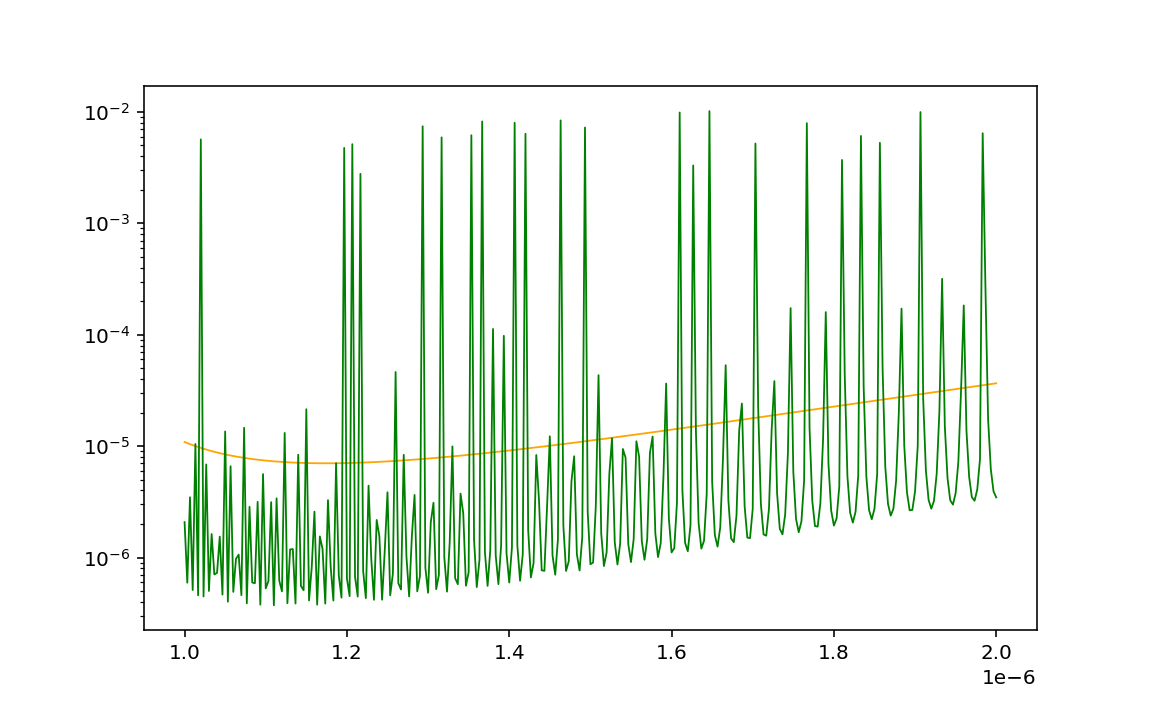

In [64]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(wls, -betasN2.imag, color='orange', linewidth=.9)
plt.plot(wls, -betasN3.imag, color='green', linewidth=.9)
plt.yscale('log')


# With avg loss from refindx site of PVC

In [66]:
n = 300
betas1 = np.zeros_like(wls, dtype=complex)

n_air = 1.00027717
n_glass = 1.4388164768221814
n_poly = 1.5 - 1.3675171717171715e-05j

In [67]:
ts = [15e-6, .42e-6, 12.48e-6, 10e-6, 60e-6, 10e-6]
ns = [lambda x:n_air, lambda x:n_glass,
      lambda x:n_air, lambda x:n_glass,
      lambda x:n_poly, lambda x:n_air]

mats = ['air','glass','air','glass','polymer','air']
maxhs = [.2, .01, .2, .01, .01, 10]
scale = 15e-6


Having a hard time getting the fundamental, it's jumping to a higher order mode, let's look where it is.

In [68]:
A = BraggExact(ts=ts, ns=ns , mats=mats, maxhs=maxhs, wl=wls[0], scale=scale,
              no_mesh=True)

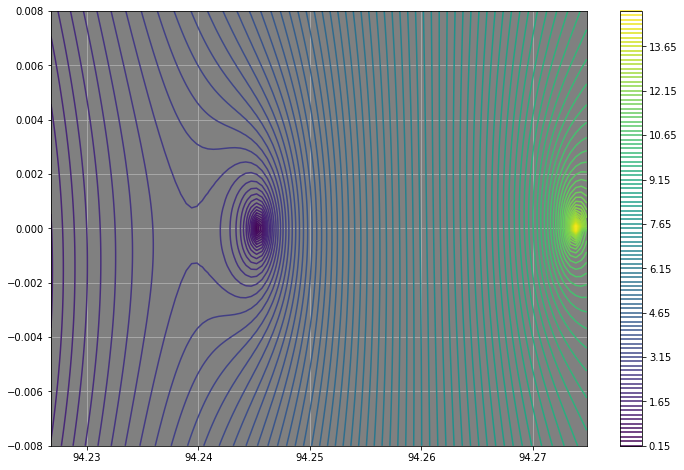

In [69]:
%matplotlib inline
k_low = A.ks[0].real * A.scale

plotlogf(A.determinant, .9995*k_low, 1.00001*k_low, -.008,.008, nu, outer,
         iref=100, rref=100, levels=100)

Lower than I thought, okay

In [70]:
guess = np.array(.9999*k_low)

beta1 = newton(A.determinant, guess, args=(nu, outer, Ktype), tol = 1e-16)

print("Scaled beta: ", beta1, ". Residual of determinant: ", abs(A.determinant(beta1, nu, outer, Ktype)))


Scaled beta:  (94.2454104071016-3.225171556228089e-06j) . Residual of determinant:  2.0454358326869977e-11


In [71]:
for i, wl in enumerate(wls):
    print(5 * ' ' +  + 20 * '-' + '  ' + str(i+1) + '/' + str(n+1) + ': ' +
          'wavelength: ' +  str(wls[i]) + '  ' +  20 * '-' +5 * ' '+'\n')
    
    A = BraggExact(ts=ts, ns=ns , mats=mats,maxhs=maxhs, wl=wl, scale=scale,
                  no_mesh=True)
    k_low = A.ks[0] * A.scale
    guess = np.array(.9999 * k_low)
    imag = 0
    flag = True
    reduce = 0

    while flag:
        try:
            x0 = np.array(guess + imag*1j)
            beta = newton(A.determinant, x0, args=(nu, outer), tol = 1e-17)
            if beta.real > k_low:
                print("Captured wrong mode, retrying.")
                raise RuntimeError
            elif beta.imag > 0:
                print("Positive imaginary part, retrying.")
                imag = -beta.imag
                guess *= 1/.999995
                raise RuntimeError
            else:
                print("Scaled beta: ", beta, ". Residual of determinant: ", 
                      abs(A.determinant(beta, nu, outer)), '\n\n' )
                imag = beta.imag
                flag=False
        except RuntimeError:
            guess *= .999995
            reduce += 1
            print("scaling guess: " + str(reduce), flush=True)
    betas1[i] = beta
    

     --------------------  1/301: wavelength: 1e-06  --------------------     

Scaled beta:  (94.24541040710159-3.2251715563235016e-06j) . Residual of determinant:  1.0485626056328543e-10 


     --------------------  2/301: wavelength: 1.0033333333333332e-06  --------------------     

Scaled beta:  (93.93204061463032-7.054552121976915e-07j) . Residual of determinant:  9.59112472438152e-11 


     --------------------  3/301: wavelength: 1.0066666666666666e-06  --------------------     

scaling guess: 1
Scaled beta:  (93.62079988528484-2.284197748271915e-06j) . Residual of determinant:  5.853079475125476e-11 


     --------------------  4/301: wavelength: 1.0099999999999999e-06  --------------------     

scaling guess: 1
Scaled beta:  (93.31156547963259-7.251203567487971e-07j) . Residual of determinant:  1.8965435562351437e-10 


     --------------------  5/301: wavelength: 1.0133333333333333e-06  --------------------     

Scaled beta:  (93.00441300203586-1.945705651131711e-06j)

Scaled beta:  (83.64190078848434-4.214961449147267e-07j) . Residual of determinant:  4.1751804221378857e-10 


     --------------------  40/301: wavelength: 1.13e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (83.42164552936492-0.003849634648211063j) . Residual of determinant:  6.025459295288585e-11 


     --------------------  41/301: wavelength: 1.1333333333333332e-06  --------------------     

Scaled beta:  (83.14947236887943-5.3243746530934e-07j) . Residual of determinant:  1.2825916131968487e-10 


     --------------------  42/301: wavelength: 1.1366666666666667e-06  --------------------     

Scaled beta:  (82.90541069758272-8.01443619949455e-07j) . Residual of determinant:  1.411064169480301e-10 


     --------------------  43/301: wavelength: 1.1399999999999999e-06  --------------------     

Scaled beta:  (82.66280755402633-2.168289415120472e-06j) . Residual of determinant:  1.0713596663176041e-10 


     -----------------

scaling guess: 1
Scaled beta:  (75.38188140754045-5.943785243878019e-06j) . Residual of determinant:  3.075273914069324e-12 


     --------------------  77/301: wavelength: 1.2533333333333333e-06  --------------------     

Scaled beta:  (75.18116646058719-4.991083261403666e-07j) . Residual of determinant:  1.109299364581269e-10 


     --------------------  78/301: wavelength: 1.2566666666666666e-06  --------------------     

Scaled beta:  (74.98152949054526-9.045970007037625e-07j) . Residual of determinant:  7.971516853386936e-12 


     --------------------  79/301: wavelength: 1.26e-06  --------------------     

Scaled beta:  (74.78299463834695-8.943793551973663e-06j) . Residual of determinant:  2.933623606611504e-12 


     --------------------  80/301: wavelength: 1.2633333333333332e-06  --------------------     

scaling guess: 1
Scaled beta:  (74.58544202633257-5.2998334647143e-07j) . Residual of determinant:  7.001459010187297e-10 


     --------------------  81/301: wavel

Scaled beta:  (68.43843477390723-6.076548608093531e-07j) . Residual of determinant:  3.105580042771527e-10 


     --------------------  115/301: wavelength: 1.38e-06  --------------------     

Scaled beta:  (68.27290684613622-1.2100983760855007e-06j) . Residual of determinant:  1.0001985301818197e-10 


     --------------------  116/301: wavelength: 1.3833333333333334e-06  --------------------     

scaling guess: 1
scaling guess: 2
Scaled beta:  (68.1082598337431-7.43630214516896e-05j) . Residual of determinant:  3.2752452038282887e-12 


     --------------------  117/301: wavelength: 1.3866666666666666e-06  --------------------     

scaling guess: 1
Scaled beta:  (67.94427069169583-9.964105488259747e-07j) . Residual of determinant:  3.155374289680353e-11 


     --------------------  118/301: wavelength: 1.3899999999999998e-06  --------------------     

Scaled beta:  (67.78111779624491-6.446544444442561e-07j) . Residual of determinant:  1.701528367940091e-11 


     -----------

Scaled beta:  (62.94393862370684-8.305667714372633e-07j) . Residual of determinant:  1.0489722939435738e-10 


     --------------------  151/301: wavelength: 1.5e-06  --------------------     

Scaled beta:  (62.80384433278013-1.3957462515123853e-06j) . Residual of determinant:  7.005277551665609e-12 


     --------------------  152/301: wavelength: 1.5033333333333333e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (62.70320133237156-0.003902212753134195j) . Residual of determinant:  1.4443539968392043e-10 


     --------------------  153/301: wavelength: 1.5066666666666665e-06  --------------------     

Scaled beta:  (62.52556008130558-3.0893718746298074e-06j) . Residual of determinant:  1.561482328774555e-12 


     --------------------  154/301: wavelength: 1.51e-06  --------------------     

Scaled beta:  (62.38731035306718-9.488440883337823e-07j) . Residual of determinant:  1.4525570769303348e-10 


     ------

Scaled beta:  (58.144430936444515-1.4477235039167011e-06j) . Residual of determinant:  5.024965461322599e-11 


     --------------------  188/301: wavelength: 1.6233333333333332e-06  --------------------     

Scaled beta:  (58.02481749775344-1.2272808233499653e-06j) . Residual of determinant:  7.132514055952514e-11 


     --------------------  189/301: wavelength: 1.6266666666666666e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (57.90569116377062-2.385541602394765e-06j) . Residual of determinant:  3.6061249992198653e-11 


     --------------------  190/301: wavelength: 1.6299999999999999e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
Scaled beta:  (57.82730349372143-0.004474367570196193j) . Residual of determinant:  9.92771417848403e-11 


     --------------------  191/301: wavelength: 1.633333333333333e-06  --------------------     

Scaled bet

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
scaling guess: 5
scaling guess: 6
scaling guess: 7
scaling guess: 8
scaling guess: 9
scaling guess: 10
Scaled beta:  (54.16544941235486-0.005680134317448757j) . Residual of determinant:  1.481213028255222e-11 


     --------------------  224/301: wavelength: 1.7433333333333333e-06  --------------------     

scaling guess: 1
Scaled beta:  (54.02344409394512-1.327693668184141e-05j) . Residual of determinant:  1.7798608312664458e-12 


     --------------------  225/301: wavelength: 1.7466666666666665e-06  --------------------     

Scaled beta:  (53.92009902604672-2.833107044942833e-06j) . Residual of determinant:  1.5376757156661615e-11 


     --------------------  226/301: wavelength: 1.7499999999999998e-06  --------------------     

scaling guess: 1
Scaled beta:  (53.8171685716641-1.7713230715236898e-06j) . Residual of determinant:  1.2829560896153666e-11 


     --------------------  227/301: wavelength: 1.753333

scaling guess: 1
scaling guess: 2
scaling guess: 3
scaling guess: 4
Scaled beta:  (50.99407882736727-3.431769255936706e-05j) . Residual of determinant:  3.85611580440905e-12 


     --------------------  256/301: wavelength: 1.8499999999999999e-06  --------------------     

Scaled beta:  (50.90192368393503-5.307069587628795e-06j) . Residual of determinant:  9.696874266316695e-12 


     --------------------  257/301: wavelength: 1.853333333333333e-06  --------------------     

Scaled beta:  (50.81014086990674-2.719978416006013e-06j) . Residual of determinant:  1.9328599091435635e-11 


     --------------------  258/301: wavelength: 1.8566666666666665e-06  --------------------     

Scaled beta:  (50.718693060886345-2.3908975295352707e-06j) . Residual of determinant:  1.9399289770201613e-11 


     --------------------  259/301: wavelength: 1.86e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (50.62757123368722-3.320592683615286e-06j) 

Scaled beta:  (47.956631046515334-8.867121776592678e-05j) . Residual of determinant:  2.2644413199616655e-13 


     --------------------  291/301: wavelength: 1.9666666666666668e-06  --------------------     

Scaled beta:  (47.8750282277586-1.041787737176461e-05j) . Residual of determinant:  1.1666730041965946e-11 


     --------------------  292/301: wavelength: 1.9699999999999998e-06  --------------------     

Scaled beta:  (47.79377702423112-4.610584083081008e-06j) . Residual of determinant:  1.7206370395440278e-12 


     --------------------  293/301: wavelength: 1.9733333333333332e-06  --------------------     

scaling guess: 1
scaling guess: 2
scaling guess: 3
Scaled beta:  (47.712811754813245-3.40578868025925e-06j) . Residual of determinant:  3.284346834065613e-11 


     --------------------  294/301: wavelength: 1.9766666666666667e-06  --------------------     

scaling guess: 1
Scaled beta:  (47.632120924201566-3.6107532181462302e-06j) . Residual of determinant:  3.6778

<IPython.core.display.Javascript object>


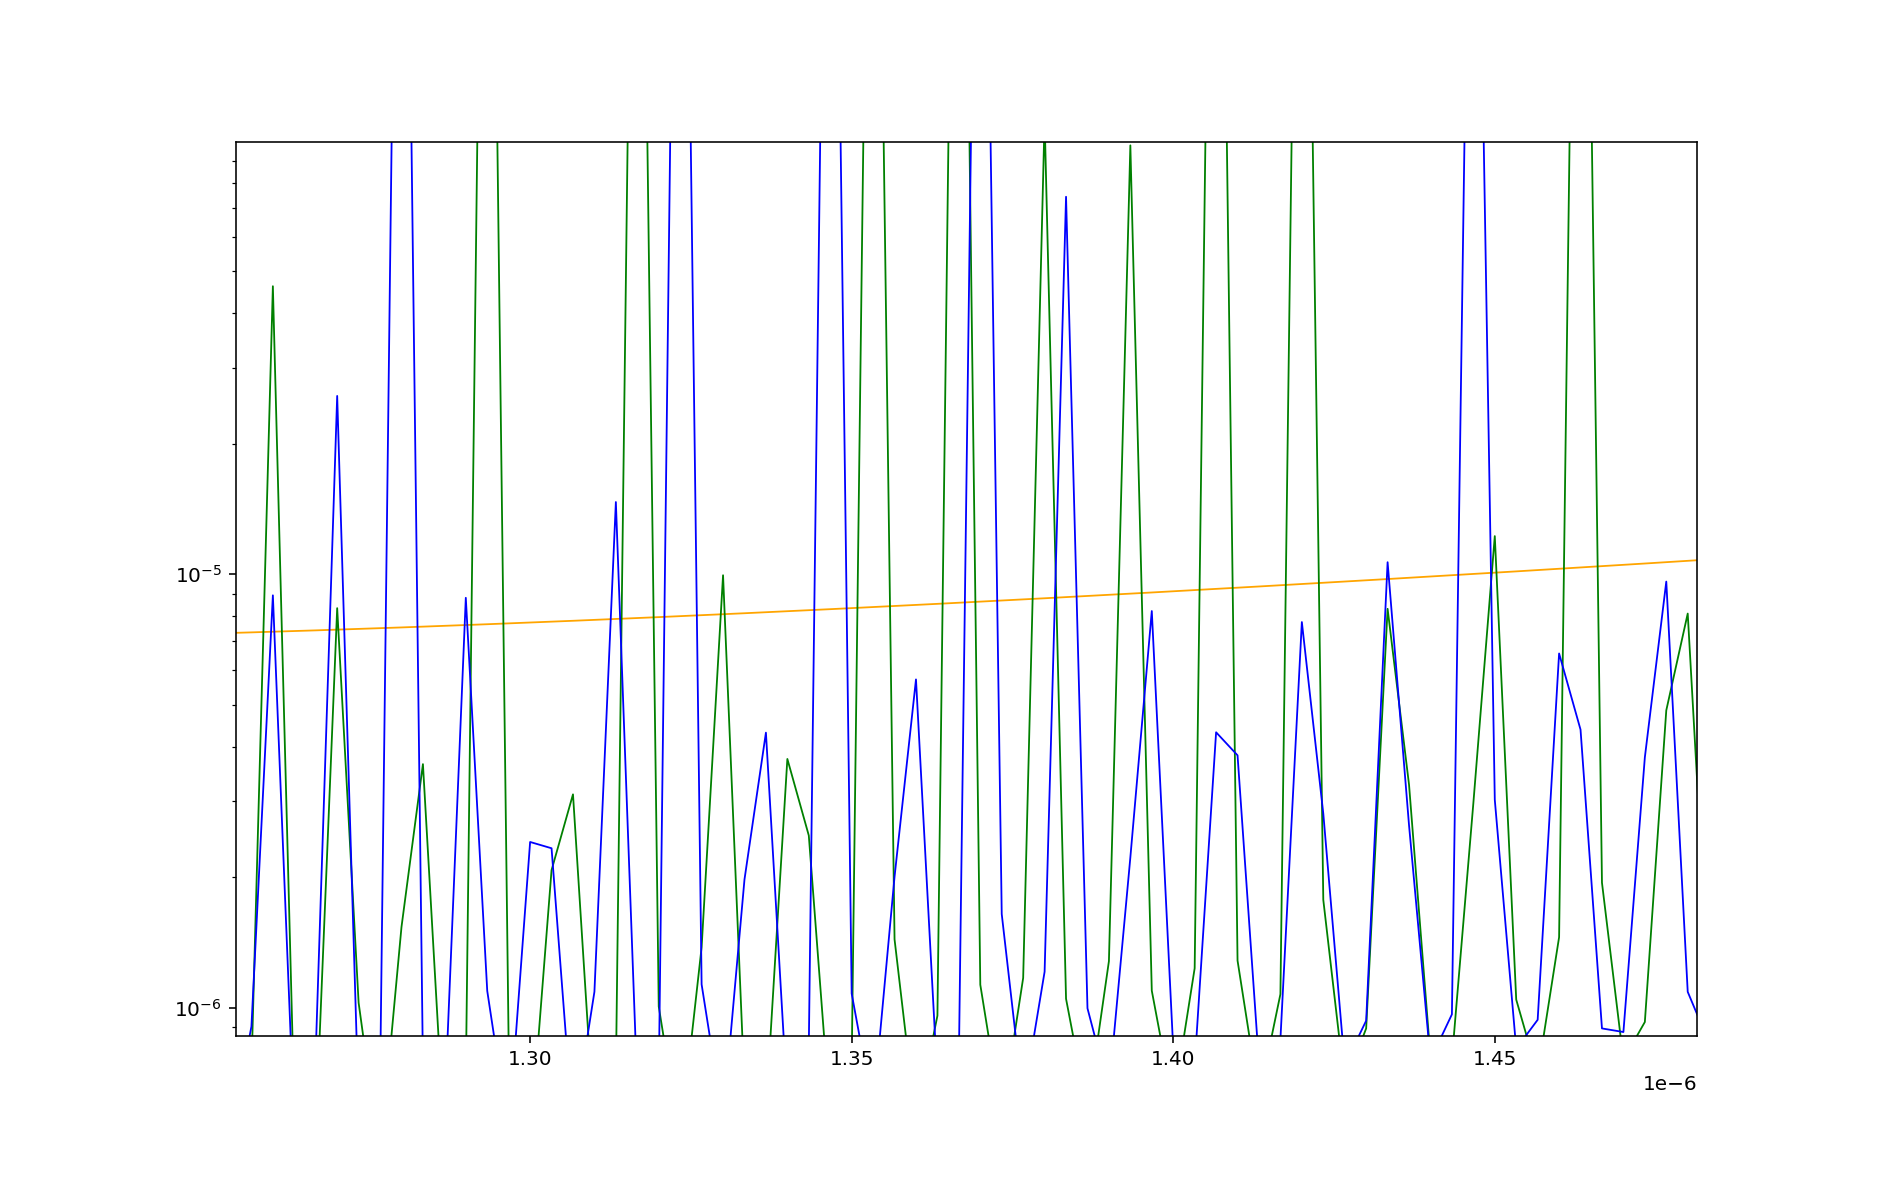

In [73]:
%matplotlib notebook
plt.figure(figsize=(8,5))
plt.plot(wls, -betasN2.imag, color='orange', linewidth=.9)
plt.plot(wls, -betasN3.imag, color='green', linewidth=.9)
plt.plot(wls, -betas1.imag, color='blue', linewidth=.9)
plt.yscale('log')


# With varying extinction coeff

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
info = np.genfromtxt('PMMA.csv', delimiter=',', skip_header=1)

In [3]:
L, R = .4, 2

r, c = (R - L) / 2, (R + L) / 2  # center c and radius r to find range of coeffs we want to view

In [4]:
pmma = info[np.where(np.abs(info[:,0]-c)<r)]

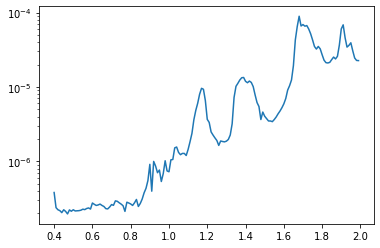

In [5]:
plt.plot(pmma[:,0], pmma[:,2])
plt.yscale('log')

In [36]:
info = np.genfromtxt('PVC.csv', delimiter=',', skip_header=1)

In [37]:
L, R = 1, 2

r, c = (R - L) / 2, (R + L) / 2  # center c and radius r to find range of coeffs we want to view

In [38]:
pvc= info[np.where(np.abs(info[:,0]-c)<r)]

In [39]:
np.mean(pvc[:,2])

1.3675171717171715e-05

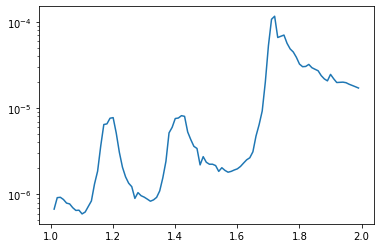

In [40]:
plt.plot(pvc[:,0], pvc[:,2])
plt.yscale('log')